In [2]:
!pip install beautifulsoup4

In [0]:
! wget https://www.kaggle.com/c/fake-news/download/AO9U8R5K3SUwN02tAygk%2Fversions%2FgguQVVmM6pmkraHdF4dh%2Ffiles%2Ftrain.csv -O fake_news_dataset.csv
! wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/latest/noncomm_use_subset.tar.gz -O data.tar.gz
!tar xvzf data.tar.gz

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
%cd /
%cd /content/drive/My\ Drive/LHD
!ls


In [0]:
import bs4 
from urllib.request import urlopen
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Парсим PDF файлы с исследованиями

In [12]:
import json
from tqdm.notebook import tqdm
csv = open('real_news.csv', 'w')
csv.write("text{delim}label\n")

for path in tqdm(os.listdir(path="noncomm_use_subset/pdf_json")):
    path='noncomm_use_subset/pdf_json/'+path
    f= open(path, 'r')
    data=json.loads(f.read())
    string=''
    for s in data['body_text']:
        if 'text' in s:
            string+=s['text']+' '
    csv.write(string+'{delim}'+'0\n')


In [4]:
import pandas as pd
real = pd.read_csv('real_news.csv', delimiter='{delim}')
real

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,text,label
0,When oxygen is delivered through nasal cathete...,0
1,"For centuries, camels have played a significan...",0
2,Viruses are not only notorious for their patho...,0
3,With the phenomenal increase in the number of ...,0
4,Translation is a tightly regulated step of gen...,0
...,...,...
2461,Hantaviruses represent one of the important em...,0
2462,"In 2015, there was a nationwide outbreak of Mi...",0
2463,Resistance to death is a major characteristic ...,0
2464,Intrinsically disordered proteins (IDPs) and i...,0


In [88]:
text=''
f = open('text.txt', 'w')
for i,string in enumerate(shuffle(real['text'] ).head(64)):
    f.write(string+"\n")
print(i)
f.close()

63


In [63]:
!pip3 install textgenrnn

Генерируем текст по примерам с помощью LSTM

In [0]:
from textgenrnn import textgenrnn
textgen = textgenrnn()

In [0]:
model_cfg = {
    'word_level': False,   # set to True if want to train a word-level model (requires more data and smaller max_length)
    'rnn_size': 128,   # number of LSTM cells of each layer (128/256 recommended)
    'rnn_layers': 3,   # number of LSTM layers (>=2 recommended)
    'rnn_bidirectional': False,   # consider text both forwards and backward, can give a training boost
    'max_length': 30,   # number of tokens to consider before predicting the next (20-40 for characters, 5-10 for words recommended)
    'max_words': 10000,   # maximum number of words to model; the rest will be ignored (word-level model only)
}

train_cfg = {
    'line_delimited': False,   # set to True if each text has its own line in the source file
    'num_epochs': 5,   # set higher to train the model for longer
    'gen_epochs': 1,   # generates sample text from model after given number of epochs
    'train_size': 0.8,   # proportion of input data to train on: setting < 1.0 limits model from learning perfectly
    'dropout': 0.0,   # ignore a random proportion of source tokens each epoch, allowing model to generalize better
    'validation': False,   # If train__size < 1.0, test on holdout dataset; will make overall training slower
    'is_csv': False   # set to True if file is a CSV exported from Excel/BigQuery/pandas
}

In [0]:
textgen = textgenrnn()

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path='text.txt',
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=1024,
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=100,
    word_level=model_cfg['word_level'])

In [0]:
textgen.generate_to_file('gen_file.txt',
                         temperature=0.5,max_gen_length=512,n=512)


In [109]:
from tqdm.notebook import tqdm
csv = open('fakes.csv', 'w')
csv.write("text{delim}label\n")

for string in tqdm(open('gen_file.txt', 'r').read().split('\n')):
    csv.write(string+'{delim}'+'1\n')


In [5]:
fake = pd.read_csv('fakes.csv', delimiter='{delim}')
fake

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,text,label
0,", ""children"", ""however"", ""net"" ""deffect"", ""can...",1
1,activity against a common better that the cont...,1
2,ant with the protein to the change in the aggr...,1
3,reatment of the combination of SINV ( Fig. 3B ...,1
4,ons in surviving the accumulation of the conta...,1
...,...,...
443,th the potential cases of the presence of IL-3...,1
444,"""however, the fecal studies to the major three...",1
445,"ith ""deliment"", ""sterovactin"", ""correct"", ""hea...",1
446,of influenza virus infections in parasites of ...,1


In [6]:
real=real.head(448)
real

,text,label
0,When oxygen is delivered through nasal cathete...,0
1,"For centuries, camels have played a significan...",0
2,Viruses are not only notorious for their patho...,0
3,With the phenomenal increase in the number of ...,0
4,Translation is a tightly regulated step of gen...,0
...,...,...
443,Infectious gastroenteritis are one of the main...,0
444,"Since its discovery in 1976, the Ebola virus h...",0
445,Middle East respiratory syndrome (MERS) has be...,0
446,Korea has designated notifying infectious dise...,0


In [0]:
data=shuffle(pd.concat([real,fake]))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.33, random_state=42)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

Векторизуем текст

In [11]:
vec=TfidfVectorizer(stop_words='english')
vec.fit(X_train)
train_matr=vec.transform(X_train)
#print(train_matr)
print(print("Shape=", train_matr.shape))
test_matr=vec.transform(X_test)
#print(test_matr)
print(print("Shape=", test_matr.shape))

Shape= (600, 39382)
None
Shape= (296, 39382)
None


Создаем Байесовский классификатор

In [12]:
from sklearn.naive_bayes import MultinomialNB
cls=MultinomialNB()
from sklearn.model_selection import cross_val_score
scores = cross_val_score(cls , train_matr, y_train, cv=5,scoring="accuracy")
print(scores.mean())


0.9983333333333334


In [0]:
cls.fit(train_matr,y_train)
scores.mean()
y_pred=cls.predict(test_matr)


Смотрим как хороо работает классификатор

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       1.00      1.00      1.00       138

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


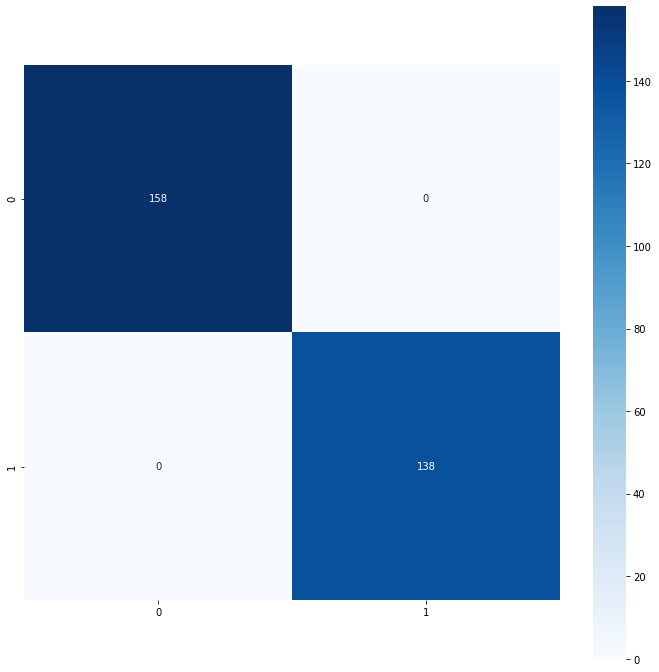

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print(classification_report(y_test, y_pred))
plt.figure(figsize=(12,12)) 
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

Сохраняем модельку

In [0]:
import pickle
f=open('model.model','wb')
pickle.dump(cls,f)
f.close()
f=open('model.vec','wb')
pickle.dump(vec,f)
f.close()